Abuzyar Tazetdinov

a.tazetdinov@innopolis.university

Group -- SD-02

In [1]:
import os

USE_GPU = True

if USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Task 1

## Read data in Python. Split your data into train and test sets (80% and 20% respectively).

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("android_traffic.csv")

print(data.iloc[:3])

X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, :-1],
    data.iloc[:, -1],
    test_size=0.2,
    random_state=42,
)

print(f"X_train (shape = {X_train.shape})")
print(f"X_test (shape = {X_test.shape})")
print(f"y_train (shape = {y_train.shape})")
print(f"y_test (shape = {y_test.shape})")

   tcp_packets  dist_port_tcp  external_ips  vulume_bytes  udp_packets  \
0           36              6             3          3911            0   
1          117              0             9         23514            0   
2          196              0             6         24151            0   

   source_app_packets  remote_app_packets  source_app_bytes  remote_app_bytes  \
0                  39                  33              5100              4140   
1                 128                 107             26248             24358   
2                 205                 214            163887             24867   

   source_app_packets.1  dns_query_times    type  
0                    39                3  benign  
1                   128               11  benign  
2                   205                9  benign  
X_train (shape = (6276, 11))
X_test (shape = (1569, 11))
y_train (shape = (6276,))
y_test (shape = (1569,))


## Create the following three models:
* RandomForestClassifier(max_depth=15)
* BaggingClassifier(base_estimator=DecisionTreeClassifier(max depth=15))
* AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max depth=15))

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

rf_clf = RandomForestClassifier(max_depth=15)
b_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))

## Tune the following hyper-parameters of the estimators in all ensemble models using grid search:
* n_estimators
* max_features --> for the base estimators
* min_impurity_decrease --> for the base estimators

You should tune these hyper-parameters within the ensemble not separately. Create the final models
using the best values of the hyper-parameters and evaluate your models on the test set. Which model
performed the best on the test set? Why do you think that is the case?

In [12]:
from sklearn.model_selection import GridSearchCV


def tune_clf(clf, param_grid, X, y):
    grid_search_clf = GridSearchCV(clf, param_grid)
    grid_search_clf.fit(X, y)
    return grid_search_clf.best_params_


param_grid_with_base = {
    "n_estimators": [30, 40, 50, 60, 70],
    "base_estimator__max_features": list(range(1, 11)),
    "base_estimator__min_impurity_decrease": [0.05 * i for i in range(4)],
}

param_grid_without_base = {
    "n_estimators": [30, 40, 50, 60, 70],
}

In [13]:
best_rf_params = tune_clf(rf_clf, param_grid_without_base, X_train, y_train)

In [14]:
print("RandomForestClassifier")
print("Best params:", best_rf_params)

rf_clf = RandomForestClassifier(max_depth=15, n_estimators=best_rf_params["n_estimators"])
rf_clf.fit(X_train, y_train)

print("Accuracy:", rf_clf.score(X_test, y_test))

RandomForestClassifier
Best params: {'n_estimators': 40}
Accuracy: 0.89993626513703


In [15]:
best_b_params = tune_clf(b_clf, param_grid_with_base, X_train, y_train)

In [16]:
print("BaggingClassifier")
print("Best params:", best_b_params)

b_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(
        max_depth=15,
        max_features=best_b_params["base_estimator__max_features"],
        min_impurity_decrease=best_b_params["base_estimator__min_impurity_decrease"],
    ),
    n_estimators=best_b_params["n_estimators"],
)
b_clf.fit(X_train, y_train)

print("Accuracy:", b_clf.score(X_test, y_test))

BaggingClassifier
Best params: {'base_estimator__max_features': 3, 'base_estimator__min_impurity_decrease': 0.0, 'n_estimators': 70}
Accuracy: 0.9005736137667304


In [17]:
best_ab_params = tune_clf(ab_clf, param_grid_with_base, X_train, y_train)

In [18]:
print("AdaBoostClassifier")
print("Best params:", best_ab_params)

ab_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        max_depth=15,
        max_features=best_ab_params["base_estimator__max_features"],
        min_impurity_decrease=best_ab_params["base_estimator__min_impurity_decrease"],
    ),
    n_estimators=best_ab_params["n_estimators"],
)
ab_clf.fit(X_train, y_train)

print("Accuracy:", ab_clf.score(X_test, y_test))

AdaBoostClassifier
Best params: {'base_estimator__max_features': 6, 'base_estimator__min_impurity_decrease': 0.0, 'n_estimators': 70}
Accuracy: 0.9037603569152326


AdaBoostClassifier is the best performed model.
I think this is related to fact that AdaBoost oriented to
more optimization.

## Answer this question before doing the next part.

If you fine-tuned the hyper-parameter max depth as
well, which of the three ensemble models would you expect to have deeper (larger max depth value)
base learners and which would have shallower base learners? Why do you think that would be the
case?

AdaBoostClassifier will have shallower base learners
because AdaBoost oriented to tuning weak learners.
Other models will have larger max depth.

## Initialize the models with the best parameters you got from the third step.
Fine tune max depth from 5 to 25. Draw 3 plots on the same graph. Put the max depth parameter on the horizontal axis and
the cross validation accuracy of your ensemble models on the vertical axis. Do the results agree with
your answer in the previous part?

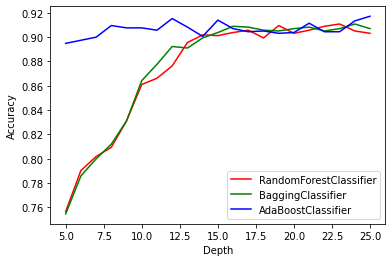

In [19]:
import matplotlib.pyplot as plt

xs = list(range(5, 26))
rf_ys = []
b_ys = []
ab_ys = []

for depth in xs:
    rf_clf = RandomForestClassifier(max_depth=depth, n_estimators=best_rf_params["n_estimators"])
    rf_clf.fit(X_train, y_train)
    rf_ys.append(rf_clf.score(X_test, y_test))

    b_clf = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(
            max_depth=depth,
            max_features=best_b_params["base_estimator__max_features"],
            min_impurity_decrease=best_b_params["base_estimator__min_impurity_decrease"],
        ),
        n_estimators=best_b_params["n_estimators"],
    )
    b_clf.fit(X_train, y_train)
    b_ys.append(b_clf.score(X_test, y_test))

    ab_clf = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(
            max_depth=depth,
            max_features=best_ab_params["base_estimator__max_features"],
            min_impurity_decrease=best_ab_params["base_estimator__min_impurity_decrease"],
        ),
        n_estimators=best_ab_params["n_estimators"],
    )
    ab_clf.fit(X_train, y_train)
    ab_ys.append(ab_clf.score(X_test, y_test))

plt.plot(xs, rf_ys, label="RandomForestClassifier", c="red")
plt.plot(xs, b_ys, label="BaggingClassifier", c="green")
plt.plot(xs, ab_ys, label="AdaBoostClassifier", c="blue")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Results agree with previous except BaggingClassifier and RandomForestClassifier.
They are constantly swapping 2 and 3 places,
I think it can be said that result are almost the same.

About max_depth, AdaBoost have good results where max_depth is not very large
and other models have better results with larger max_depth.

# Task 2

## Preprocess and visualize the dataset: [50%]

Read all images and convert them to gray with (cv2.ctvColor())

In [20]:
from pathlib import Path

# This flag separate execution into 2 branches:
# 1 - We work with original dataset and this is useful when we do it in local machine.
# 2 - We train network on Colab or another remote service, so we don't want to upload all dataset again and again
# if session closes. Instead of this we upload just one pickle file and it will be easier and faster.
# ATTENTION: use only trusted pickle files, because any code can be injected via it. For production
# environment another kind of serialization of data should be considered.
USE_PICKLE = True

# If SAVE_PICKLE is True, one image of original size, labels for this image, and entire dataset with cropped eye
# regions and labels for them will be saved into pickle file.
SAVE_PICKLE = not USE_PICKLE

# Name of pickle file.
PICKLE_FILE = Path("./data.pkl")

In [21]:
import pickle


def read_pickle(
        pickle_file: Path,
) -> dict:
    with open(pickle_file, "rb") as f:
        return pickle.load(f)


if USE_PICKLE:
    pickle_data = read_pickle(PICKLE_FILE)

In [22]:
import cv2
import numpy as np
from typing import Dict

dataset_dir = Path("gi4e_database/")
images_dir = dataset_dir / Path("images")


def read_images(
        directory: Path,
        extension: str = ".png",
) -> Dict[str, np.array]:
    images_dict = {}
    for i in directory.iterdir():
        if not i.name.endswith(extension):
            continue
        images_dict[i.name] = cv2.cvtColor(cv2.imread(str(i)), cv2.COLOR_BGR2GRAY)
    return images_dict


if not USE_PICKLE:
    images_dict = read_images(images_dir)

Read annotation for images. It contains eye corners and eye centers of 2 eyes for each image.

In [23]:
from typing import List

labels_file = dataset_dir / Path("labels/image_labels.txt")


def read_labels(
        labels_file: Path,
) -> Dict[str, List[float]]:
    labels_dict = {}
    with open(labels_file, "r", encoding="utf-8") as f:
        for line in f:
            stripped = line.strip()
            if not stripped:
                continue
            image_filename, *labels_list_as_str = stripped.split("\t")
            labels_dict[image_filename] = list(map(float, labels_list_as_str))
    return labels_dict


if not USE_PICKLE:
    labels_dict = read_labels(labels_file)
    assert len(images_dict) == len(labels_dict)

Visualize one image, draw eye corners and iris centers on it

Labels: [493.23, 185.03, 479.95, 183.33, 465.89, 184.5, 431.9, 184.89, 416.67, 183.46, 403.91, 185.03]
Labels as int: [493, 185, 480, 183, 466, 184, 432, 185, 417, 183, 404, 185]


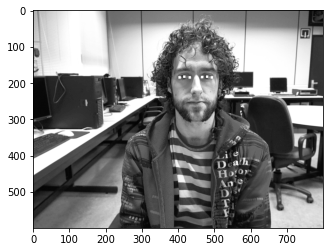

In [24]:
from typing import List
from copy import deepcopy

from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rc("image", cmap="gray")


def convert_labels_to_int(labels: List[float]) -> List[int]:
    return list(map(lambda i: int(round(i, ndigits=0)), labels))


one_image_name = "007_07.png"
if not USE_PICKLE:
    one_image = deepcopy(images_dict[one_image_name])
    one_image_labels = labels_dict[one_image_name]
else:
    one_image = pickle_data["one_image"]
    one_image_labels = pickle_data["one_image_labels"]

labels_as_int = convert_labels_to_int(one_image_labels)
print("Labels:", one_image_labels)
print("Labels as int:", labels_as_int)

square_half = 3
for i in range(0, len(labels_as_int), 2):
    x, y = labels_as_int[i:i + 2]
    cv2.rectangle(
        one_image,
        (x - square_half, y + square_half),
        (x + square_half, y - square_half),
        (255, 0, 0),
        -1,
    )

# xxx_yy.png	x1 y1 x2 y2 x3 y3 x4 y4 x5 y5 x6 y6
# The first point (x1, y1) is the external corner of the left user's eye.
# The second point (x2, y2) is the centre of the left iris.
# The third one (x3, y3) is the internal corner of the left eye.
# The other three points are internal corner (x4, y4),
# iris centre (x5, y5) and
# external corner (x6, y6) of the right eye.


plt.imshow(one_image)
plt.show()

Normalize images (divide by 255)

In [25]:
if not USE_PICKLE:
    for name in images_dict:
        images_dict[name] = images_dict[name] / 255

Crop eye regions (and resize if needed) to be (48x48) image with the help of eye corners. Do that
for all images. It should look like Figure3(a).

In [26]:
from typing import Tuple
import numpy as np


def normalize_borders(
        left: int,
        right: int,
        square_size: int,
) -> (int, int):
    left, right = min(left, right), max(left, right)
    diff = right - left
    rest = square_size - diff
    if diff < square_size:
        if rest % 2 == 1:
            left -= 1
            rest -= 1
        left -= rest // 2
        right += rest // 2
    elif diff > square_size:
        if rest % 2 == 1:
            left += 1
            rest -= 1
        left += rest // 2
        right -= rest // 2

    return left, right


def crop_eye(
        image: np.array,
        x_left: int,
        y_left: int,
        x_iris: int,
        y_iris: int,
        x_right: int,
        y_right: int,
        square_size: int = 48,
) -> (np.array, Tuple[int, int]):
    x_left, x_right = min(x_left, x_right), max(x_left, x_right)

    y_left, y_right = normalize_borders(y_left, y_right, square_size)
    cropped_image = image[y_left:y_right, x_left:x_right]
    cropped_image = cv2.resize(cropped_image, (square_size, square_size))

    x_ = x_left
    y_ = y_left
    new_x_iris = round(x_iris - x_ + (square_size - (x_right - x_left)) / 2)
    new_y_iris = y_iris - y_

    return cropped_image, (new_x_iris, new_y_iris)

In [27]:
if not USE_PICKLE:
    cropped_images_dict = {}
    for name in images_dict:
        labels_as_int = convert_labels_to_int(labels_dict[name])
        x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = labels_as_int
        cropped_images_dict[f"{name}_left"] = crop_eye(
            images_dict[name], x1, y1, x2, y2, x3, y3
        )
        cropped_images_dict[f"{name}_right"] = crop_eye(
            images_dict[name], x6, y6, x5, y5, x4, y4
        )

    plt.imshow(cropped_images_dict[f"{one_image_name}_left"][0])
    print(cropped_images_dict[f"{one_image_name}_left"][1])
    plt.show()
    print(cropped_images_dict[f"{one_image_name}_left"][0].shape)

Now data is ready to create a final dataset, which you will use for CNN training. You should
create two np arrays X and Y:
- X contains (48x48) images of eye regions which you crop on previous step
- Your labels (Y) are coordinates of eye center for each image in X (don’t forget to convert iris
center from whole image coordinate system to coordinate system of eye region). You should make
one more step to cook Y set. For each eye center in Y you should create a (48x48) image (with
zero values) and assign value=1 to pixel which coordinate is an iris center. Do it for all images.
It should look like Figure3(b)

Finally, your X and Y sets are lists of 48x48 images. X contains images of eye and Y images with
white pixel on the place of iris center.

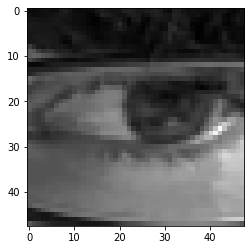

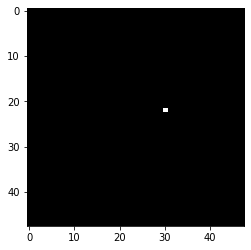

In [28]:
if not USE_PICKLE:
    X = []
    y = []
    for image, iris_center in cropped_images_dict.values():
        X.append(np.expand_dims(image, axis=2))
        y.append(np.zeros((48, 48, 1), dtype="int8"))
        y[-1][iris_center[1], iris_center[0]] = 1

    X = np.array(X)
    y = np.array(y)

    if SAVE_PICKLE:
        with open(PICKLE_FILE, "wb") as f:
            pickle.dump({
                "one_image": one_image,
                "one_image_labels": one_image_labels,
                "X": X,
                "y": y,
            }, f)
else:
    X = pickle_data["X"]
    y = pickle_data["y"]

    plt.imshow(X[0, :, :, 0])
    plt.show()
    plt.imshow(y[0, :, :, 0])
    plt.show()

Split dataset

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [30]:
print(f"X_train (shape = {X_train.shape})")
print(f"X_test (shape = {X_test.shape})")
print(f"y_train (shape = {y_train.shape})")
print(f"y_test (shape = {y_test.shape})")

X_train (shape = (1977, 48, 48, 1))
X_test (shape = (495, 48, 48, 1))
y_train (shape = (1977, 48, 48, 1))
y_test (shape = (495, 48, 48, 1))


## Build a CNN model using Keras. Layers that might be helpful: Conv2, Conv2DTranspose, concatenate. [20%]

In [31]:
from keras.layers import Conv2D, Conv2DTranspose, concatenate
from keras import Model, Input


def get_layers(activation: str):
    # 48x48x1
    inlayer = Input(shape=(48, 48, 1), name="inlayer")

    # 48x48x64
    y = Conv2D(64, (3, 3), strides=(1, 1), activation=activation, padding="same")(inlayer)

    # 24x24x128
    x = Conv2D(128, (3, 3), strides=(2, 2), activation=activation, padding="same")(y)

    # 12x12x256
    x_ = Conv2D(256, (3, 3), strides=(2, 2), activation=activation, padding="same")(x)

    # 48x48x64
    x = Conv2DTranspose(64, (3, 3), strides=(4, 4), activation=activation, padding="same")(x_)

    # 48x48x128
    x = concatenate([x, y], name="concatenate")

    # 48x48x64
    x = Conv2D(64, (3, 3), strides=(1, 1), activation=activation, padding="same")(x)

    # 48x48x1
    x = Conv2DTranspose(1, (3, 3), strides=(1, 1), padding="same", activation=activation,
                        name="position_output")(x)

    # 12x12x256
    encoder = Conv2D(256, (3, 3), strides=(1, 1), activation=activation, padding="same")(x_)

    # 24x24x128
    encoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation=activation, padding="same")(encoder)

    # 48x48x64
    encoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation=activation, padding="same")(encoder)

    # 48x48x1
    encoder = Conv2DTranspose(1, (3, 3), strides=(1, 1), activation=activation, padding="same",
                              name="original_output")(encoder)

    return inlayer, x, encoder


def make_model_for_training(hp):
    activation = hp.Choice(f"activation", values=["relu", "tanh", "sigmoid"])
    inlayer, original_output, position_output = get_layers(activation)

    model = Model(inputs=inlayer, outputs=[original_output, position_output], name=f"model_for_training")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", "adamax", "rmsprop"])
    loss = hp.Choice("loss", values=["mse", "mae"])
    model.compile(optimizer=optimizer, loss=loss)

    return model

## Compile and train CNN with different optimizers [sgd, adam, adamax, rmsprop], loss functions [mse, mae] and activations [tanh, relu, sigmoid]. Report best combination. [20%]

In [32]:
def find_max(a) -> tuple:
    m = -1
    for y in range(48):
        for x in range(48):
            if a[y, x] > m:
                res = (x, y)
                m = a[y, x]
    return res

In [35]:
def tune_hyperparameters():
    for activation in ("relu", "tanh", "sigmoid"):
        for loss in ("mse", "mae"):
            for optimizer in ("sgd", "adam", "adamax", "rmsprop"):
                inlayer, original_output, position_output = get_layers(activation)
                model_for_training = Model(inputs=inlayer, outputs=[position_output, original_output],
                                           name=f"model_for_training")
                model_for_training.compile(optimizer=optimizer, loss=loss)
                for e in range(1, 4):
                    model_for_training.fit(
                        X_train,
                        {
                            "position_output": y_train,
                            "original_output": X_train,
                        },
                        epochs=10,
                        validation_split=0.2,
                    )

                    print(f"{activation} - {loss} - {optimizer} - epoch {10 * e}")

                    y_pred = np.array(model_for_training.predict(X_test[:3]))
                    for i in range(y_pred.shape[1]):
                        truth_x, truth_y = find_max(y_test[i])
                        pred_x, pred_y = find_max(y_pred[1][i])
                        plt.imshow(X_test[i])
                        plt.scatter(pred_x, pred_y, c="red")
                        plt.scatter(truth_x, truth_y, c="yellow")
                        plt.show()

                        plt.imshow(y_pred[0, i])
                        plt.show()

# tune_hyperparameters()

Using function above I've explored the best combination:
optimizer = "adamax", loss = "mse", activation = "tanh"

In [46]:
import matplotlib.pyplot as plt

optimizer = "adamax"
loss = "mse"
activation = "tanh"

# we need to build model manually for keeping layers in global scope
# this is necessary for compiling model for production

inlayer, original_output, position_output = get_layers(activation)
model_for_training = Model(inputs=inlayer, outputs=[position_output, original_output], name=f"model_for_training")
model_for_training.compile(optimizer=optimizer, loss=loss)

history = model_for_training.fit(
    X_train,
    {
        "position_output": y_train,
        "original_output": X_train,
    },
    epochs=300,
    validation_split=0.2,
)

Epoch 1/300
50/50 [==============================] - 3s 33ms/step - loss: 4.5965e-04 - original_output_loss: 6.4935e-06 - position_output_loss: 4.5316e-04 - val_loss: 4.3434e-04 - val_original_output_loss: 5.2431e-07 - val_position_output_loss: 4.3382e-04

In [47]:
def plot(history) -> None:
    for a, b in (
            ("original_output_loss", "val_original_output_loss"),
            ("position_output_loss", "val_position_output_loss"),
            ("loss", "val_loss"),
    ):
        plt.plot(list(range(len(history.history[a]))), history.history[a], label=a)
        plt.plot(list(range(len(history.history[b]))), history.history[b], label=b)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

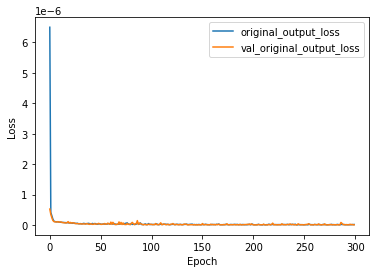

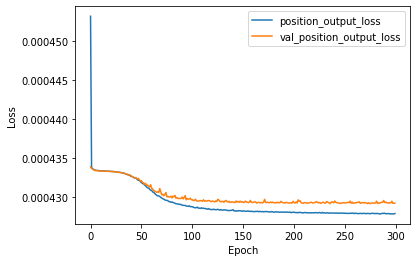

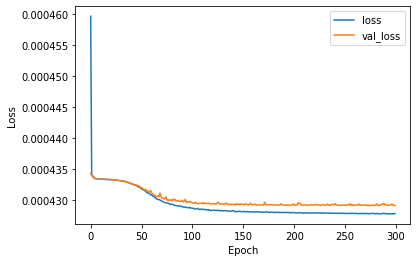

In [48]:
plot(history)

## Make a prediction for 10 test images. Draw predicted centers on them and visualize it. (You can draw iris center with cv2.circle()). [10%]

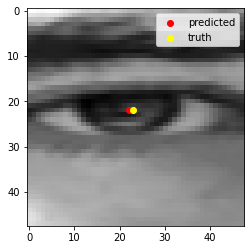

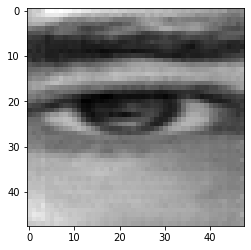

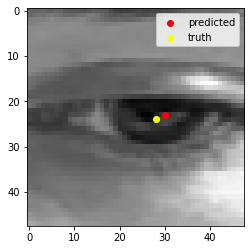

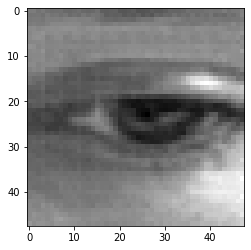

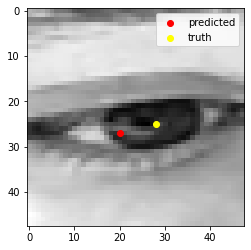

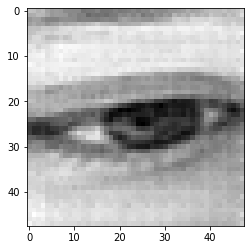

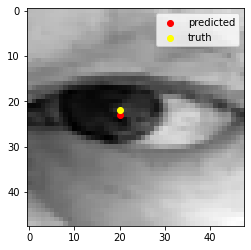

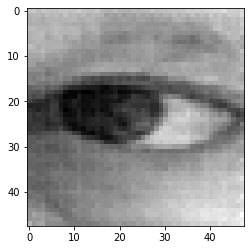

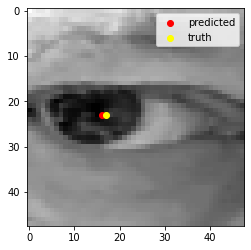

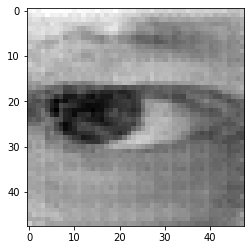

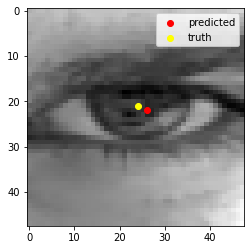

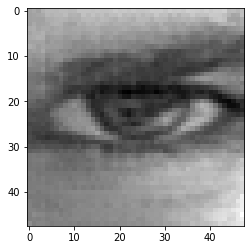

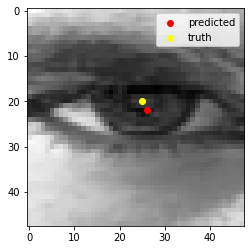

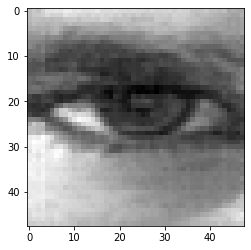

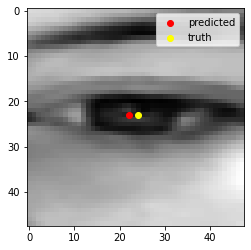

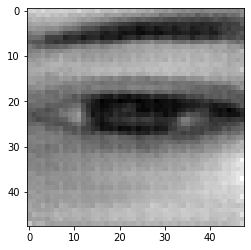

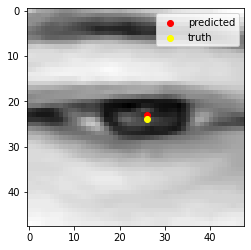

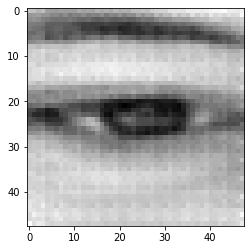

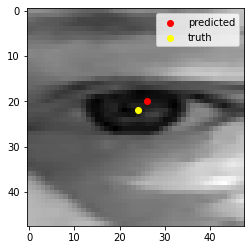

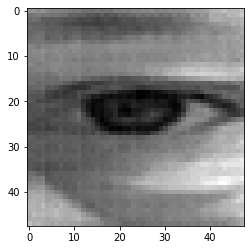

In [54]:
y_pred = np.array(model_for_training.predict(X_test[:10]))
for i in range(y_pred.shape[1]):
    truth_x, truth_y = find_max(y_test[i])
    pred_x, pred_y = find_max(y_pred[1][i])
    plt.imshow(X_test[i])
    plt.scatter(pred_x, pred_y, c="red", label="predicted")
    plt.scatter(truth_x, truth_y, c="yellow", label="truth")
    plt.legend()
    plt.show()

    plt.imshow(y_pred[0, i])
    plt.show()

For production, we need to compile model without auxiliary network.

In [55]:
model_for_production = Model(inputs=inlayer, outputs=position_output, name=f"model_for_production")
model_for_production.compile(optimizer=optimizer, loss=loss)
model_for_production.summary()

Model: "model_for_production"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inlayer (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 256)       590080    
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 24, 24, 128)      295040    
 Transpose)                                                      
                                              